# 게임 유저 A/B 테스트

**사용자가 게임을 진행하면서 인앱 구매를 하기 전에 잠시 기다려야 하는 게이트를 만나게 됩니다. 이 노트북은 첫 번째 게이트가 레벨 30에서 레벨 40으로 이동한 A/B 테스트 결과를 분석한 것입니다.**

---
## 목차

> 1. [라이브러리](#라이브러리)
> 2. [데이터 로드](#데이터)
> 3. [통계치 요약](#통계치)
> 4. [이상치 확인/제거](#이상치)
> 5. [세부 분석](#세부)
> 6. [A/B 테스트](#ab)
> 7. [결론](#결론)
---

<p>90189명의 데이터. 변수는 다음과 같습니다.</p>
<ul>
<li><code>userid</code> - 유저 ID</li>
<li><code>version</code> - 통제 그룹 여부 </br>    (<code>gate_30</code> - 통제 그룹) </br>
(<code>gate_40</code> - 테스트 그룹).
</li>
<li><code>sum_gamerounds</code> - 게임 설치 후 첫 주 동안 플레이어가 플레이한 게임 라운드 수
<li><code>retention_1</code> - 설치 후 1일 후에 게임 플레이 여부 </br>
(True, False)</li>
<li><code>retention_7</code> - 설치 후 7일 후에 게임 플레이 여부</br>
(True, False)
</li>
</ul>

### 1. 라이브러리<a name="라이브러리"></a>


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os

# 가설검정
from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)


### 2. 데이터 로드<a name="데이터"></a>

In [ ]:
path = "cookie_cats.csv"

df = pd.read_csv(path)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [ ]:
df.isnull().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

### 3.통계치 요약 <a name="통계치"></a>

In [ ]:
df.describe([0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.99])[["sum_gamerounds"]].T

,count,mean,std,min,10%,20%,30%,40%,50%,60%,70%,80%,90%,99%,max
sum_gamerounds,90189.0,51.872457,195.050858,0.0,1.0,3.0,6.0,11.0,16.0,25.0,40.0,67.0,134.0,493.0,49854.0


In [ ]:
df.groupby("version").sum_gamerounds.agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44700,17.0,52.456264,256.716423,49854
gate_40,45489,16.0,51.298776,103.294416,2640


### 4. 이상치 확인 및 제거 <a name="이상치"></a>

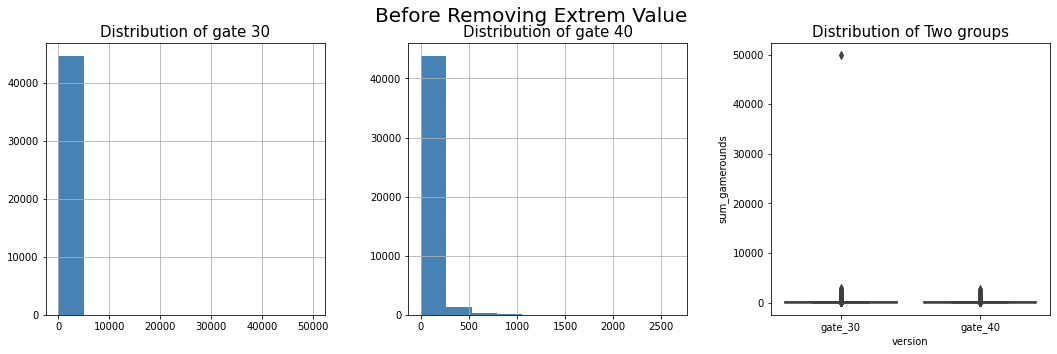

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df[df["version"] == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="steelblue")
df[df["version"] == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="steelblue")
sns.boxplot(x=df["version"], y=df["sum_gamerounds"], ax=axes[2])

plt.suptitle("Before Removing Extrem Value", fontsize=20)
axes[0].set_title("Distribution of gate 30", fontsize=15)
axes[1].set_title("Distribution of gate 40", fontsize=15)
axes[2].set_title("Distribution of Two groups", fontsize=15)

plt.show()

In [ ]:
df = df[df["sum_gamerounds"] < df["sum_gamerounds"].max()]

df.describe()["sum_gamerounds"].T

count    90188.000000
mean        51.320253
std        102.682719
min          0.000000
25%          5.000000
50%         16.000000
75%         51.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

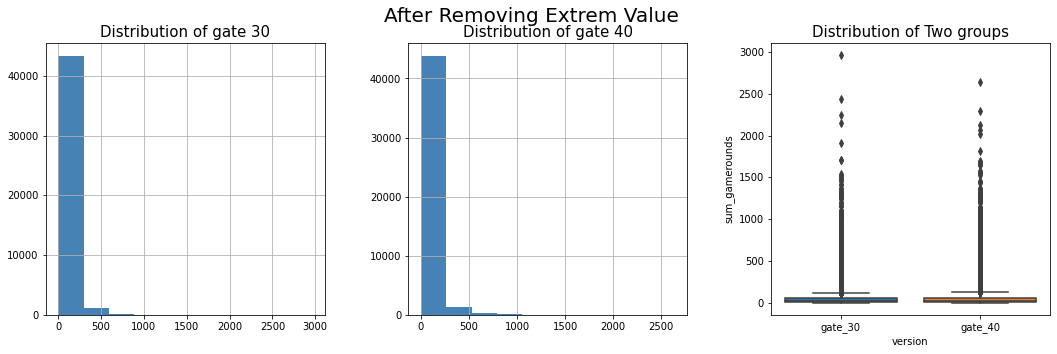

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

df[df["version"] == "gate_30"].hist("sum_gamerounds", ax=axes[0], color="steelblue")
df[df["version"] == "gate_40"].hist("sum_gamerounds", ax=axes[1], color="steelblue")
sns.boxplot(x=df["version"], y=df["sum_gamerounds"], ax=axes[2])

plt.suptitle("After Removing Extrem Value", fontsize=20)
axes[0].set_title("Distribution of gate 30", fontsize=15)
axes[1].set_title("Distribution of gate 40", fontsize=15)
axes[2].set_title("Distribution of Two groups", fontsize=15)

plt.show()

Text(0.5, 0.98, 'After Removing Extreme Value')

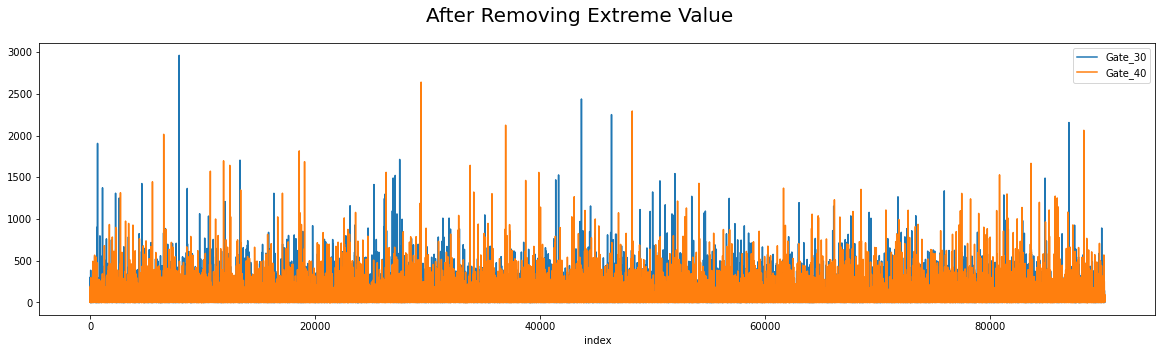

In [ ]:
df[df["version"] == "gate_30"].reset_index().set_index("index")["sum_gamerounds"].plot(legend=True, label="Gate_30", figsize=(20, 5))
df[df["version"] == "gate_40"].reset_index().set_index("index")["sum_gamerounds"].plot(legend=True, label="Gate_40")
plt.suptitle("After Removing Extreme Value", fontsize=20)

### 5. 세부 분석 <a name="세부"></a>

**게임을 설치한 사람 중 3994명은 한번도 게임을 하지 않았습니다.** 그 이유는 다음과 같을 것입니다.

- 게임할 시간이 없다.
- 다른 게임을 더 좋아한다.
- 사용자들이 앱을 좋아하지 않는다.

**라운드가 진행됨에 따라 사용자 수가 감소합니다.**

- 대부분의 유저들은 초반에 게임을 하고 게임을 진행하지 않았습니다.
- 이는 게임 데이터를 분석 해야 하는 이유입니다.
- 게임 및 사용자에 대한 조사 및 데이터 수집은 사용자 이탈을 이해하는 데 도움이 됩니다.
- 게임의 난이도를 측정할 수 있습니다.
- 선물은 플레이어 유지에 도움이 될 수 있습니다.

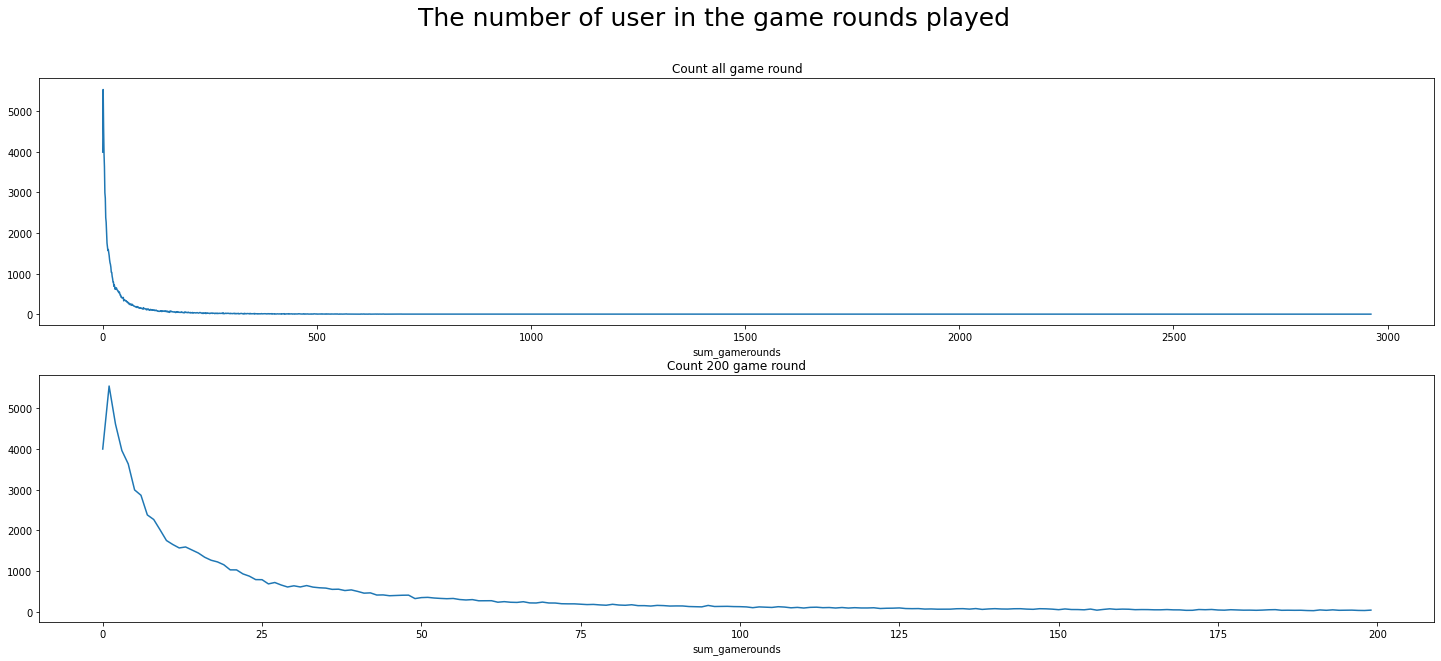

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(25, 10))

df.groupby("sum_gamerounds").userid.count().plot(ax = ax[0])
df.groupby("sum_gamerounds").userid.count()[:200].plot(ax = ax[1])

plt.suptitle("The number of user in the game rounds played", fontsize=25)
ax[0].set_title("Count all game round")
ax[1].set_title("Count 200 game round")
plt.show()

In [ ]:
df.groupby("sum_gamerounds").userid.count().reset_index().head(20)

,sum_gamerounds,userid
0,0,3994
1,1,5538
2,2,4606
3,3,3958
4,4,3629
5,5,2992
6,6,2861
7,7,2379
8,8,2267
9,9,2013


In [ ]:
df.groupby("sum_gamerounds").userid.count().loc[[30,40]]

sum_gamerounds
30    642
40    505
Name: userid, dtype: int64

요약통계를 보면 통제집단과 실험집단이 비슷해 보이지만 이것을 통계적으로 검증할 것입니다.

In [ ]:
df.groupby("version")["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

,count,median,mean,std,max
version,,,,,
gate_30,44699,17.0,51.342111,102.057598,2961
gate_40,45489,16.0,51.298776,103.294416,2640


**retention 변수 분석을 통해 다음과 같은 결과를 얻었습니다.**
- 플레이어의 55%는 게임 설치 1일 후 게임을 하지 않았습니다.
- 플레이어의 81%는 게임 설치 7일 후 게임을 하지 않았습니다.

In [ ]:
pd.DataFrame({"retention_1_ratio":df["retention_1"].value_counts() / len(df),
             "retention_7_ratio":df["retention_7"].value_counts() / len(df)})

,retention_1_ratio,retention_7_ratio
False,0.554786,0.813944
True,0.445214,0.186056


버전별 retention 변수의 요약 통계를 살펴보고 sum_gamerounds와 비교하면 그룹 간에 유사점이 있습니다. 그러나 통계적으로 유의한 차이가 있는지는 확인을 해야합니다.

In [ ]:
df.groupby(["version", "retention_1"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median       mean         std   max
version retention_1                                            
gate_30 False        24665     6.0  16.359092   36.528426  1072
        True         20034    48.0  94.411700  135.037697  2961
gate_40 False        25370     6.0  16.340402   35.925756  1241
        True         20119    49.0  95.381182  137.887256  2640

In [ ]:
df.groupby(["version", "retention_7"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version retention_7                                             
gate_30 False        36198    11.0   25.796508   43.316158   981
        True          8501   105.0  160.117516  179.358560  2961
gate_40 False        37210    11.0   25.856356   44.406112  2640
        True          8279   111.0  165.649837  183.792499  2294

게임 설치 후 1일, 7일 후에 플레이 하거나 하지 않은 이용자 수에서도 비슷한 결과가 나왔습니다. 전체 사용자 중 약 12000명의 사용자가 게임을 설치한 후 1일, 7일 후에 게임을 했습니다. 전체 사용자의 14%는 앞으로 게임을 계속할 사람들을 포함될 것입니다.

In [ ]:
df["Retention"] = np.where((df["retention_1"] == True) & (df["retention_7"] == True), 1, 0)
df.groupby(["version", "Retention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"])

count  median        mean         std   max
version Retention                                             
gate_30 0          38023    12.0   28.070273   48.017452  1072
        1           6676   127.0  183.886309  189.626390  2961
gate_40 0          38983    12.0   28.103353   48.927850  2640
        1           6506   133.0  190.282355  194.220077  2294

retention 변수를 결합하고 두 그룹을 비교한 요약 통계량도 유사합니다.

In [ ]:
df["NewRetention"] = list(map(lambda x, y : str(x)+"-"+str(y), df["retention_1"], df["retention_7"]))
df.groupby(["version", "NewRetention"])["sum_gamerounds"].agg(["count", "median", "mean", "std", "max"]).reset_index()

,version,NewRetention,count,median,mean,std,max
0,gate_30,False-False,22840,6.0,11.819746,21.642643,981
1,gate_30,False-True,1825,43.0,73.169315,93.222330,1072
2,gate_30,True-False,13358,33.0,49.694490,58.125396,918
3,gate_30,True-True,6676,127.0,183.886309,189.626390,2961
4,gate_40,False-False,23597,6.0,11.913294,20.901020,547
5,gate_40,False-True,1773,47.0,75.261139,94.478048,1241
6,gate_40,True-False,13613,32.0,50.025490,60.924587,2640
7,gate_40,True-True,6506,133.0,190.282355,194.220077,2294


### 6. A/B test <a name="ab"></a>

### Assumptions:
- 정규성 확인
- 만약 데이터가 정규분포를 따르면 분산의 동질성을 확인
​
### Steps:
- 통제집단과 비교집답으로 구분
- 정규성 확인을 위한 shapiro wilk 검정을 시행
- 분산의 동질성 검정을 위해 Levene Test 시행
- 만약 정규분포를 따르지 않는다면 Whitney U Test 진행

In [ ]:
df["version"] = np.where(df["version"]=="gate_30", "A", "B")
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7,Retention,NewRetention
0,116,A,3,False,False,0,False-False
1,337,A,38,True,False,0,True-False
2,377,B,165,True,False,0,True-False
3,483,B,1,False,False,0,False-False
4,488,B,179,True,True,1,True-True


In [ ]:
groupA = df[df["version"] == "A"]["sum_gamerounds"]
groupB = df[df["version"] == "B"]["sum_gamerounds"]

In [ ]:
ntA = shapiro(groupA)[1] < 0.05
ntB = shapiro(groupB)[1] < 0.05

if ntA==False and ntB==False:
    leveneTest = stats.levene(groupA, groupB)[1] < 0.05
    if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Heterogeneous
        ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
else:
    # Non-Parametric Test
    ttest = stats.mannwhitneyu(groupA, groupB)[1] 
print(ntA, ntB)

True True


In [ ]:
temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })

temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")

if (ntA == False) & (ntB == False):
    temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
    temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
else:
    temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]

print("# A/B Testing Hypothesis")
print("H0: A == B")
print("H1: A != B", "\n")

temp

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.025446,A/B groups are not similar!


In [ ]:
df.groupby("version").retention_1.mean(), df.groupby("version").retention_7.mean()

(version
 A    0.448198
 B    0.442283
 Name: retention_1, dtype: float64, version
 A    0.190183
 B    0.182000
 Name: retention_7, dtype: float64)

### 7. 결론 <a name="결론"></a>

A/B 테스팅을 적용한 후 분석 결과, 몇 가지 정보를 알아냈습니다. Shapiro Testing은 정규분포를 따른다는 가정에 대해 H0를 기각했습니다. 따라서 두 그룹을 비교하기 위해 Mann Whitney U라는 비모수 테스트를 적용해야 했습니다. 결과적으로 Mann Whitney U Testing은 H0 가설을 거부했고 A/B 그룹은 유사하지 않다는 것을 알아냈습니다.

게임 라운드에서 첫 번째 게이트를 레벨 30에서 레벨 40으로 이동하는 것에 대해 두 그룹 간에 통계적으로 유의한 차이가 있습니다.

### 플레이어 유지 측면에서 더 유리한 게이트창 활성화 레벨은?

1일 및 7일 평균 retention 변수는 게이트가 레벨 40일 때보다 레벨 30일 때 더 높습니다. 따라서 gate창은 레벨 30에 나오도록 하는게 플레이어 유지에 더 도움될 것입니다.
